### Import library and model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import random

### Import, Scale and Split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('..\Dataset\EUR.csv')
 # GBP - VND
gbp = pd.read_csv("..\Dataset\GBP.csv")
 # JPY - VND
jpy = pd.read_csv("..\Dataset\JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

### MinMaxScaler

In [3]:
# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))

### Standardizate function

In [4]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

### Prepare data

In [5]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

### Forecast

In [6]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test, time_step):
    x_input = test[len(test)-time_step:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps=time_step
    i=0
    while(i<=90):
        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

### Visualize

In [7]:
# Function to visualize the model
def visualize_MLP(model, train, test, pre_test, f3, f6, f9, time_step):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', end='6/1/2024', freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+time_step:],scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))
    plt.title('MLP Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

### Evaluate

In [8]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE(%) =',mape)
    print('MAE =',mae)

### Set seed

- Ensure that your model is always initialized and trained with the same random seed (đảm bảo rằng mô hình của bạn sẽ luôn được khởi tạo và huấn luyện với cùng một chuỗi số ngẫu nhiên => cùng một kết quả mỗi khi chạy lại chương trình)

- Ensure that differences in results are not due to differences in random numbers but rather due to differences in the nature of the models. (đảm bảo rằng sự khác biệt trong kết quả không phải do sự khác biệt trong số ngẫu nhiên mà do sự khác biệt trong bản chất của các mô hình)

### Implement

In [9]:
def implement_MLP(train, test):
    # set seed
    np.random.seed(0)
    tf.random.set_seed(0)
    random.seed(0)
    
    # Time step
    time_step = 40
    
    # Convert train and test data
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    
    # Define MLP model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=time_step))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit model
    model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=0)
    
    # Predict test data
    pre_test = model.predict(X_test)
    
    # Forecast next 30, 60, 90 days
    forecast30, forecast60, forecast90 = forecast_days(model, test, time_step)
    
    # Visualize model
    visualize_MLP(model, train, test, pre_test, forecast30, forecast60, forecast90, time_step)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    evaluate(pre_test, test[time_step:])

# EUR - VND


In [10]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
 ## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
 ## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.8711341]
41
1 day input [0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.8711341 ]
1 day output [[0.8789736]]
2 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.8711341  0.8789736 ]
2 

17 day output [[0.9443324]]
18 day input [0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.8711341  0.8789736
 0.88366932 0.88887966 0.89028573 0.89812416 0.89709073 0.90396309
 0.90914863 0.91383272 0.91682583 0.91888857 0.92145741 0.92949718
 0.9388082  0.94279766 0.94197637 0.94433242]
18 day output [[0.94793355]]
19 day input [0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.8711341  0.8789736  0.88366932
 0.88887966 0.89028573 0.89812416 0.89709073 0.90396309 0.90914863
 0.91383272 0.91682583 0.91888857 0.92145741 0.92949718 0.9388082
 0.94279766 0.94197637 0.94433242 0.94793355]
19 day output [[0.95218

34 day output [[0.99919045]]
35 day input [0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.8711341
 0.8789736  0.88366932 0.88887966 0.89028573 0.89812416 0.89709073
 0.90396309 0.90914863 0.91383272 0.91682583 0.91888857 0.92145741
 0.92949718 0.9388082  0.94279766 0.94197637 0.94433242 0.94793355
 0.95218468 0.95923424 0.9608143  0.95964295 0.96271616 0.96424693
 0.96813428 0.9756611  0.97749186 0.97932154 0.98212671 0.98442537
 0.98639649 0.99164242 0.99643922 0.99919045]
35 day output [[1.0048304]]
36 day input [0.87267576 0.85567558 0.86683195 0.86683195 0.8711341  0.8789736
 0.88366932 0.88887966 0.89028573 0.89812416 0.89709073 0.90396309
 0.90914863 0.91383272 0.91682583 0.91888857 0.92145741 0.92949718
 0.9388082  0.94279766 0.94197637 0.94433242 0.94793355 0.95218468
 0.95923424 0.9608143  0.95964295 0.96271616 0.96424693 0.96813428
 0.9756611  0.97749186 0.97932154 0.98212671 0.98442537 0.98639649
 0.99164242 0.99643922 0.99919045 1.00483036]
36 day output [[1.00746

53 day output [[1.0694563]]
54 day input [0.9388082  0.94279766 0.94197637 0.94433242 0.94793355 0.95218468
 0.95923424 0.9608143  0.95964295 0.96271616 0.96424693 0.96813428
 0.9756611  0.97749186 0.97932154 0.98212671 0.98442537 0.98639649
 0.99164242 0.99643922 0.99919045 1.00483036 1.00746775 1.00893211
 1.01313961 1.01837516 1.02230358 1.02601027 1.02873826 1.0306195
 1.03428018 1.04083502 1.04532909 1.04819012 1.0516336  1.0535543
 1.05708146 1.0627712  1.06630909 1.06945634]
54 day output [[1.0732899]]
55 day input [0.94279766 0.94197637 0.94433242 0.94793355 0.95218468 0.95923424
 0.9608143  0.95964295 0.96271616 0.96424693 0.96813428 0.9756611
 0.97749186 0.97932154 0.98212671 0.98442537 0.98639649 0.99164242
 0.99643922 0.99919045 1.00483036 1.00746775 1.00893211 1.01313961
 1.01837516 1.02230358 1.02601027 1.02873826 1.0306195  1.03428018
 1.04083502 1.04532909 1.04819012 1.0516336  1.0535543  1.05708146
 1.0627712  1.06630909 1.06945634 1.07328987]
55 day output [[1.075977]

71 day output [[1.1378924]]
72 day input [0.99164242 0.99643922 0.99919045 1.00483036 1.00746775 1.00893211
 1.01313961 1.01837516 1.02230358 1.02601027 1.02873826 1.0306195
 1.03428018 1.04083502 1.04532909 1.04819012 1.0516336  1.0535543
 1.05708146 1.0627712  1.06630909 1.06945634 1.07328987 1.07597697
 1.07915902 1.08384871 1.08787298 1.09133375 1.09610903 1.0993377
 1.10187805 1.10616434 1.11000693 1.11413062 1.11912119 1.12288046
 1.1255796  1.12930763 1.13372767 1.13789237]
72 day output [[1.1423811]]
73 day input [0.99643922 0.99919045 1.00483036 1.00746775 1.00893211 1.01313961
 1.01837516 1.02230358 1.02601027 1.02873826 1.0306195  1.03428018
 1.04083502 1.04532909 1.04819012 1.0516336  1.0535543  1.05708146
 1.0627712  1.06630909 1.06945634 1.07328987 1.07597697 1.07915902
 1.08384871 1.08787298 1.09133375 1.09610903 1.0993377  1.10187805
 1.10616434 1.11000693 1.11413062 1.11912119 1.12288046 1.1255796
 1.12930763 1.13372767 1.13789237 1.14238107]
73 day output [[1.1465374]

90 day output [[1.2143841]]


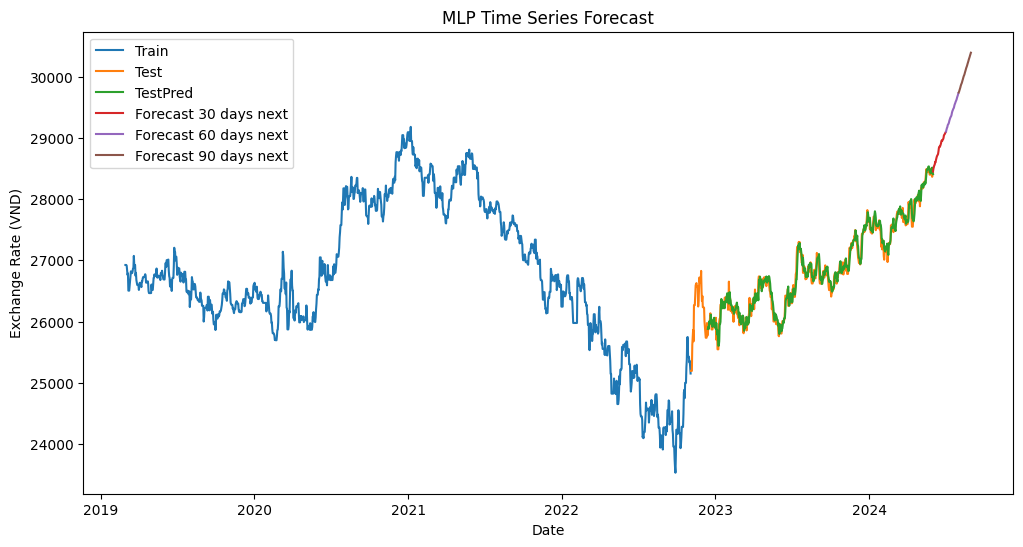

RMSE = 107.31781994284887
MAPE(%) = 0.3035325902266779
MAE = 81.33415928171662


In [11]:
implement_MLP(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.8563189]
41
1 day input [0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.85631889]
1 day output [[0.855704]]
2 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.85631889 0.85570401]
2 d

17 day output [[0.771108]]
18 day input [0.839915   0.839915   0.83832123 0.84487338 0.86116522 0.87745706
 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786
 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.85631889 0.85570401
 0.85315955 0.84896702 0.84015208 0.83935565 0.82876706 0.82359135
 0.81964362 0.81782198 0.81036162 0.80148196 0.79389268 0.79122066
 0.79152101 0.78590775 0.77661794 0.77110797]
18 day output [[0.7679566]]
19 day input [0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.85631889 0.85570401 0.85315955
 0.84896702 0.84015208 0.83935565 0.82876706 0.82359135 0.81964362
 0.81782198 0.81036162 0.80148196 0.79389268 0.79122066 0.79152101
 0.78590775 0.77661794 0.77110797 0.76795661]
19 day output [[0.76348

34 day output [[0.6947556]]
35 day input [0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.85631889
 0.85570401 0.85315955 0.84896702 0.84015208 0.83935565 0.82876706
 0.82359135 0.81964362 0.81782198 0.81036162 0.80148196 0.79389268
 0.79122066 0.79152101 0.78590775 0.77661794 0.77110797 0.76795661
 0.76348245 0.76070595 0.75582212 0.74727947 0.74112958 0.73753583
 0.73436964 0.73103386 0.72629809 0.72087187 0.71779197 0.71366513
 0.70794511 0.70251846 0.6989879  0.69475561]
35 day output [[0.6913828]]
36 day input [0.87267576 0.85567558 0.86683195 0.86683195 0.85631889 0.85570401
 0.85315955 0.84896702 0.84015208 0.83935565 0.82876706 0.82359135
 0.81964362 0.81782198 0.81036162 0.80148196 0.79389268 0.79122066
 0.79152101 0.78590775 0.77661794 0.77110797 0.76795661 0.76348245
 0.76070595 0.75582212 0.74727947 0.74112958 0.73753583 0.73436964
 0.73103386 0.72629809 0.72087187 0.71779197 0.71366513 0.70794511
 0.70251846 0.6989879  0.69475561 0.69138283]
36 day output [[0.6868

51 day output [[0.62560093]]
52 day input [0.79389268 0.79122066 0.79152101 0.78590775 0.77661794 0.77110797
 0.76795661 0.76348245 0.76070595 0.75582212 0.74727947 0.74112958
 0.73753583 0.73436964 0.73103386 0.72629809 0.72087187 0.71779197
 0.71366513 0.70794511 0.70251846 0.6989879  0.69475561 0.69138283
 0.68688935 0.68042076 0.67496312 0.67210281 0.66949117 0.66535789
 0.66009849 0.65475029 0.65056401 0.64838564 0.64521271 0.64041156
 0.63568568 0.63192105 0.62846619 0.62560093]
52 day output [[0.62198436]]
53 day input [0.79122066 0.79152101 0.78590775 0.77661794 0.77110797 0.76795661
 0.76348245 0.76070595 0.75582212 0.74727947 0.74112958 0.73753583
 0.73436964 0.73103386 0.72629809 0.72087187 0.71779197 0.71366513
 0.70794511 0.70251846 0.6989879  0.69475561 0.69138283 0.68688935
 0.68042076 0.67496312 0.67210281 0.66949117 0.66535789 0.66009849
 0.65475029 0.65056401 0.64838564 0.64521271 0.64041156 0.63568568
 0.63192105 0.62846619 0.62560093 0.62198436]
53 day output [[0.61

69 day output [[0.5607477]]
70 day input [0.71366513 0.70794511 0.70251846 0.6989879  0.69475561 0.69138283
 0.68688935 0.68042076 0.67496312 0.67210281 0.66949117 0.66535789
 0.66009849 0.65475029 0.65056401 0.64838564 0.64521271 0.64041156
 0.63568568 0.63192105 0.62846619 0.62560093 0.62198436 0.6174075
 0.61349052 0.61034119 0.6067875  0.60288805 0.59908944 0.5955404
 0.59261155 0.58976805 0.58576268 0.58146    0.57777315 0.57484096
 0.57207644 0.56887901 0.56479943 0.56074768]
70 day output [[0.557622]]
71 day input [0.70794511 0.70251846 0.6989879  0.69475561 0.69138283 0.68688935
 0.68042076 0.67496312 0.67210281 0.66949117 0.66535789 0.66009849
 0.65475029 0.65056401 0.64838564 0.64521271 0.64041156 0.63568568
 0.63192105 0.62846619 0.62560093 0.62198436 0.6174075  0.61349052
 0.61034119 0.6067875  0.60288805 0.59908944 0.5955404  0.59261155
 0.58976805 0.58576268 0.58146    0.57777315 0.57484096 0.57207644
 0.56887901 0.56479943 0.56074768 0.55762202]
71 day output [[0.5550149

87 day output [[0.5058595]]
88 day input [0.63568568 0.63192105 0.62846619 0.62560093 0.62198436 0.6174075
 0.61349052 0.61034119 0.6067875  0.60288805 0.59908944 0.5955404
 0.59261155 0.58976805 0.58576268 0.58146    0.57777315 0.57484096
 0.57207644 0.56887901 0.56479943 0.56074768 0.55762202 0.55501491
 0.55200326 0.5485546  0.54485875 0.54152465 0.53878802 0.53601485
 0.53267705 0.52928519 0.52621269 0.52337223 0.52055019 0.51748121
 0.5141716  0.51118898 0.50860173 0.50585949]
88 day output [[0.502743]]
89 day input [0.63192105 0.62846619 0.62560093 0.62198436 0.6174075  0.61349052
 0.61034119 0.6067875  0.60288805 0.59908944 0.5955404  0.59261155
 0.58976805 0.58576268 0.58146    0.57777315 0.57484096 0.57207644
 0.56887901 0.56479943 0.56074768 0.55762202 0.55501491 0.55200326
 0.5485546  0.54485875 0.54152465 0.53878802 0.53601485 0.53267705
 0.52928519 0.52621269 0.52337223 0.52055019 0.51748121 0.5141716
 0.51118898 0.50860173 0.50585949 0.50274301]
89 day output [[0.49953982

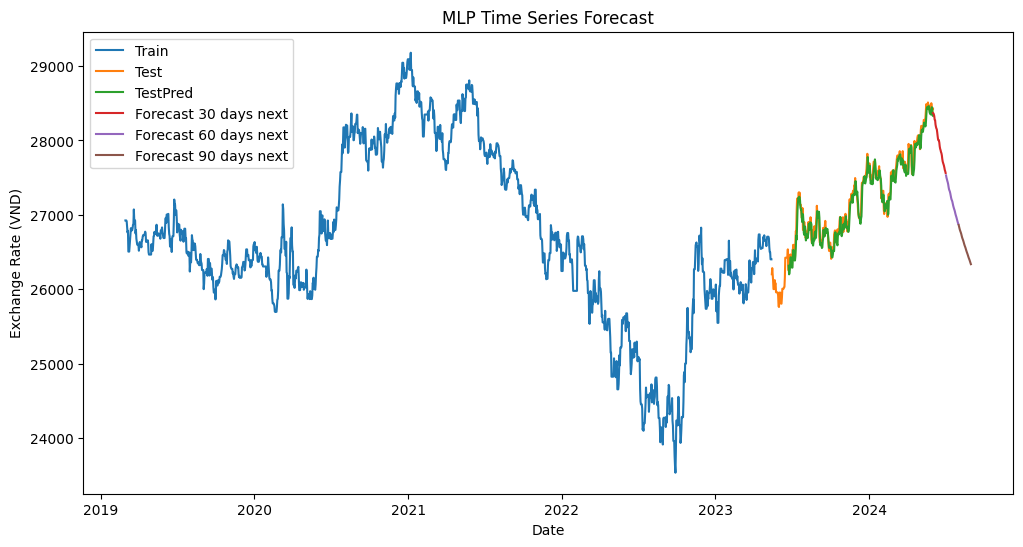

RMSE = 103.05669757646034
MAPE(%) = 0.29332316754216875
MAE = 80.0112475018169


In [12]:
implement_MLP(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[0.8699607]
41
1 day input [0.78979989 0.79847707 0.8029042  0.8029042  0.8029042  0.78448734
 0.79440411 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818
 0.82415442 0.82149814 0.82380025 0.82450859 0.839915   0.839915
 0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86996073]
1 day output [[0.87804043]]
2 day input [0.79847707 0.8029042  0.8029042  0.8029042  0.78448734 0.79440411
 0.77032052 0.79652913 0.81565433 0.82574818 0.82574818 0.82415442
 0.82149814 0.82380025 0.82450859 0.839915   0.839915   0.839915
 0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.86996073 0.87804043]
2 d

18 day output [[0.931788]]
19 day input [0.839915   0.83832123 0.84487338 0.86116522 0.87745706 0.86895697
 0.86895697 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491
 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86996073 0.87804043 0.88055122
 0.88263071 0.88137197 0.88966179 0.89045101 0.89573854 0.90105587
 0.90508568 0.90734577 0.90932059 0.91099763 0.91757971 0.92463678
 0.92649114 0.92531163 0.92869359 0.93178803]
19 day output [[0.93444717]]
20 day input [0.83832123 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697
 0.86895697 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356
 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558
 0.86683195 0.86683195 0.86996073 0.87804043 0.88055122 0.88263071
 0.88137197 0.88966179 0.89045101 0.89573854 0.90105587 0.90508568
 0.90734577 0.90932059 0.91099763 0.91757971 0.92463678 0.92649114
 0.92531163 0.92869359 0.93178803 0.93444717]
20 day output [[0.9402

37 day output [[0.9828156]]
38 day input [0.86683195 0.86683195 0.86996073 0.87804043 0.88055122 0.88263071
 0.88137197 0.88966179 0.89045101 0.89573854 0.90105587 0.90508568
 0.90734577 0.90932059 0.91099763 0.91757971 0.92463678 0.92649114
 0.92531163 0.92869359 0.93178803 0.93444717 0.94023192 0.94221914
 0.94105935 0.94334424 0.94575816 0.94921345 0.95569766 0.95590347
 0.95719355 0.96001196 0.96250194 0.96493465 0.96932447 0.97338957
 0.97410631 0.97746915 0.98043424 0.98281562]
38 day output [[0.9856027]]
39 day input [0.86683195 0.86996073 0.87804043 0.88055122 0.88263071 0.88137197
 0.88966179 0.89045101 0.89573854 0.90105587 0.90508568 0.90734577
 0.90932059 0.91099763 0.91757971 0.92463678 0.92649114 0.92531163
 0.92869359 0.93178803 0.93444717 0.94023192 0.94221914 0.94105935
 0.94334424 0.94575816 0.94921345 0.95569766 0.95590347 0.95719355
 0.96001196 0.96250194 0.96493465 0.96932447 0.97338957 0.97410631
 0.97746915 0.98043424 0.98281562 0.98560268]
39 day output [[0.9900

57 day output [[1.0394448]]
58 day input [0.93178803 0.93444717 0.94023192 0.94221914 0.94105935 0.94334424
 0.94575816 0.94921345 0.95569766 0.95590347 0.95719355 0.96001196
 0.96250194 0.96493465 0.96932447 0.97338957 0.97410631 0.97746915
 0.98043424 0.98281562 0.98560268 0.99003571 0.9925819  0.99504828
 0.99769735 0.99957842 1.00268078 1.00707793 1.00980306 1.01142836
 1.01450849 1.01647401 1.01903927 1.02345645 1.0260886  1.02789712
 1.03068817 1.03300667 1.0358367  1.0394448 ]
58 day output [[1.0422982]]
59 day input [0.93444717 0.94023192 0.94221914 0.94105935 0.94334424 0.94575816
 0.94921345 0.95569766 0.95590347 0.95719355 0.96001196 0.96250194
 0.96493465 0.96932447 0.97338957 0.97410631 0.97746915 0.98043424
 0.98281562 0.98560268 0.99003571 0.9925819  0.99504828 0.99769735
 0.99957842 1.00268078 1.00707793 1.00980306 1.01142836 1.01450849
 1.01647401 1.01903927 1.02345645 1.0260886  1.02789712 1.03068817
 1.03300667 1.0358367  1.0394448  1.0422982 ]
59 day output [[1.0444

77 day output [[1.0948218]]
78 day input [0.98560268 0.99003571 0.9925819  0.99504828 0.99769735 0.99957842
 1.00268078 1.00707793 1.00980306 1.01142836 1.01450849 1.01647401
 1.01903927 1.02345645 1.0260886  1.02789712 1.03068817 1.03300667
 1.0358367  1.0394448  1.0422982  1.04446805 1.04739571 1.05004191
 1.05239391 1.05579257 1.05885422 1.06127143 1.06406045 1.06711948
 1.06929064 1.07216573 1.07548332 1.07817411 1.08083463 1.08376741
 1.08608544 1.08868515 1.09214497 1.09482181]
78 day output [[1.0974271]]
79 day input [0.99003571 0.9925819  0.99504828 0.99769735 0.99957842 1.00268078
 1.00707793 1.00980306 1.01142836 1.01450849 1.01647401 1.01903927
 1.02345645 1.0260886  1.02789712 1.03068817 1.03300667 1.0358367
 1.0394448  1.0422982  1.04446805 1.04739571 1.05004191 1.05239391
 1.05579257 1.05885422 1.06127143 1.06406045 1.06711948 1.06929064
 1.07216573 1.07548332 1.07817411 1.08083463 1.08376741 1.08608544
 1.08868515 1.09214497 1.09482181 1.09742713]
79 day output [[1.10035

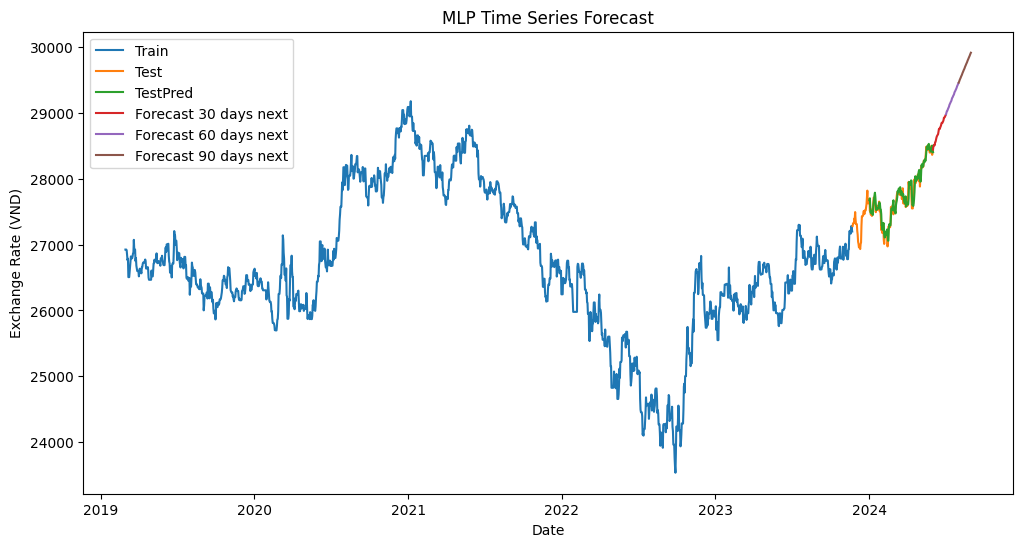

RMSE = 88.9791630136005
MAPE(%) = 0.22721570020339363
MAE = 62.903474506579094


In [13]:
implement_MLP(train_eur_3_sc, test_eur_3_sc)

# GBP - VND

In [14]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
 ## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
 ## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.97901875]
41
1 day input [0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.97901875]
1 day output [[0.99142903]]
2 day input [0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.97901875 0.9914290

19 day output [[1.1554962]]
20 day input [0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.97901875 0.99142903 1.00033295 1.00761271
 1.00745332 1.01680863 1.02086663 1.03281116 1.04261887 1.05494654
 1.06304622 1.06500518 1.07380486 1.09188032 1.11073148 1.12042487
 1.12558281 1.13107741 1.14320886 1.15549624]
20 day output [[1.1681758]]
21 day input [0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.97901875 0.99142903 1.00033295 1.00761271 1.00745332
 1.01680863 1.02086663 1.03281116 1.04261887 1.05494654 1.06304622
 1.06500518 1.07380486 1.09188032 1.11073148 1.12042487 1.12558281
 1.13107741 1.14320886 1.15549624 1.16817582]
21 day output [[1.1767

38 day output [[1.3208823]]
39 day input [0.97147147 0.97901875 0.99142903 1.00033295 1.00761271 1.00745332
 1.01680863 1.02086663 1.03281116 1.04261887 1.05494654 1.06304622
 1.06500518 1.07380486 1.09188032 1.11073148 1.12042487 1.12558281
 1.13107741 1.14320886 1.15549624 1.16817582 1.1767658  1.18374181
 1.19041991 1.19804561 1.20796716 1.21844935 1.22776055 1.23460948
 1.24247408 1.2498132  1.25783443 1.26682627 1.27813697 1.28857398
 1.29808486 1.30459285 1.3111428  1.32088232]
39 day output [[1.3315475]]
40 day input [0.97901875 0.99142903 1.00033295 1.00761271 1.00745332 1.01680863
 1.02086663 1.03281116 1.04261887 1.05494654 1.06304622 1.06500518
 1.07380486 1.09188032 1.11073148 1.12042487 1.12558281 1.13107741
 1.14320886 1.15549624 1.16817582 1.1767658  1.18374181 1.19041991
 1.19804561 1.20796716 1.21844935 1.22776055 1.23460948 1.24247408
 1.2498132  1.25783443 1.26682627 1.27813697 1.28857398 1.29808486
 1.30459285 1.3111428  1.32088232 1.3315475 ]
40 day output [[1.3432

58 day output [[1.5456396]]
59 day input [1.15549624 1.16817582 1.1767658  1.18374181 1.19041991 1.19804561
 1.20796716 1.21844935 1.22776055 1.23460948 1.24247408 1.2498132
 1.25783443 1.26682627 1.27813697 1.28857398 1.29808486 1.30459285
 1.3111428  1.32088232 1.3315475  1.34329653 1.35218573 1.35934615
 1.36681223 1.37901056 1.39383888 1.40657735 1.41582417 1.42429674
 1.43587554 1.44928157 1.46191823 1.47317064 1.48458362 1.49647152
 1.50909162 1.52134907 1.53353989 1.54563963]
59 day output [[1.5582848]]
60 day input [1.16817582 1.1767658  1.18374181 1.19041991 1.19804561 1.20796716
 1.21844935 1.22776055 1.23460948 1.24247408 1.2498132  1.25783443
 1.26682627 1.27813697 1.28857398 1.29808486 1.30459285 1.3111428
 1.32088232 1.3315475  1.34329653 1.35218573 1.35934615 1.36681223
 1.37901056 1.39383888 1.40657735 1.41582417 1.42429674 1.43587554
 1.44928157 1.46191823 1.47317064 1.48458362 1.49647152 1.50909162
 1.52134907 1.53353989 1.54563963 1.55828476]
60 day output [[1.571321

77 day output [[1.7743381]]
78 day input [1.32088232 1.3315475  1.34329653 1.35218573 1.35934615 1.36681223
 1.37901056 1.39383888 1.40657735 1.41582417 1.42429674 1.43587554
 1.44928157 1.46191823 1.47317064 1.48458362 1.49647152 1.50909162
 1.52134907 1.53353989 1.54563963 1.55828476 1.57132185 1.58333707
 1.59426594 1.60539377 1.61825407 1.63216853 1.64524198 1.65588558
 1.66580224 1.67703545 1.69009066 1.70316458 1.7148397  1.72495019
 1.73520923 1.74759507 1.76117182 1.77433813]
78 day output [[1.785796]]
79 day input [1.3315475  1.34329653 1.35218573 1.35934615 1.36681223 1.37901056
 1.39383888 1.40657735 1.41582417 1.42429674 1.43587554 1.44928157
 1.46191823 1.47317064 1.48458362 1.49647152 1.50909162 1.52134907
 1.53353989 1.54563963 1.55828476 1.57132185 1.58333707 1.59426594
 1.60539377 1.61825407 1.63216853 1.64524198 1.65588558 1.66580224
 1.67703545 1.69009066 1.70316458 1.7148397  1.72495019 1.73520923
 1.74759507 1.76117182 1.77433813 1.78579605]
79 day output [[1.79690

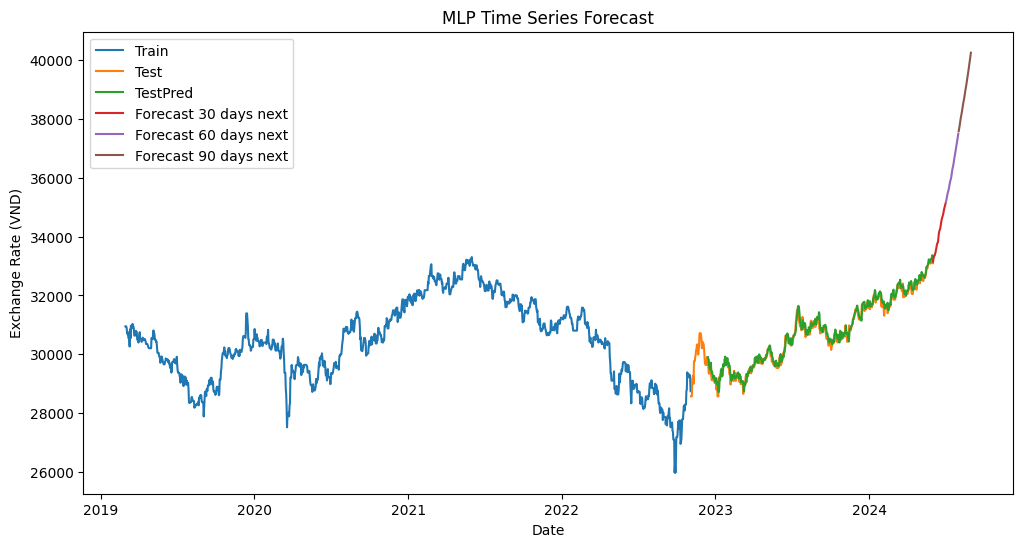

RMSE = 150.16261604719776
MAPE(%) = 0.3800559789748218
MAE = 116.52922035331163


In [15]:
implement_MLP(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.94978875]
41
1 day input [0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.94978875]
1 day output [[0.94499594]]
2 day input [0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.94978875 0.9449959

17 day output [[0.7691144]]
18 day input [0.90745291 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345
 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.94978875 0.94499594
 0.93523514 0.92499888 0.90847343 0.90069836 0.88317305 0.86913341
 0.86012816 0.85119045 0.84068519 0.82436508 0.81428778 0.80654413
 0.80236882 0.79176986 0.77911586 0.76911438]
18 day output [[0.76125795]]
19 day input [0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.94978875 0.94499594 0.93523514
 0.92499888 0.90847343 0.90069836 0.88317305 0.86913341 0.86012816
 0.85119045 0.84068519 0.82436508 0.81428778 0.80654413 0.80236882
 0.79176986 0.77911586 0.76911438 0.76125795]
19 day output [[0.754

37 day output [[0.5897597]]
38 day input [0.97147147 0.97147147 0.94978875 0.94499594 0.93523514 0.92499888
 0.90847343 0.90069836 0.88317305 0.86913341 0.86012816 0.85119045
 0.84068519 0.82436508 0.81428778 0.80654413 0.80236882 0.79176986
 0.77911586 0.76911438 0.76125795 0.75490004 0.74596781 0.73762536
 0.72511005 0.71687126 0.70909286 0.70078653 0.69173771 0.68349308
 0.67366958 0.6650697  0.65846848 0.64763653 0.63570476 0.62577081
 0.61776143 0.60876381 0.59903514 0.58975971]
38 day output [[0.58063674]]
39 day input [0.97147147 0.94978875 0.94499594 0.93523514 0.92499888 0.90847343
 0.90069836 0.88317305 0.86913341 0.86012816 0.85119045 0.84068519
 0.82436508 0.81428778 0.80654413 0.80236882 0.79176986 0.77911586
 0.76911438 0.76125795 0.75490004 0.74596781 0.73762536 0.72511005
 0.71687126 0.70909286 0.70078653 0.69173771 0.68349308 0.67366958
 0.6650697  0.65846848 0.64763653 0.63570476 0.62577081 0.61776143
 0.60876381 0.59903514 0.58975971 0.58063674]
39 day output [[0.573

58 day output [[0.4434555]]
59 day input [0.75490004 0.74596781 0.73762536 0.72511005 0.71687126 0.70909286
 0.70078653 0.69173771 0.68349308 0.67366958 0.6650697  0.65846848
 0.64763653 0.63570476 0.62577081 0.61776143 0.60876381 0.59903514
 0.58975971 0.58063674 0.5732305  0.56633759 0.55862892 0.54991657
 0.54236472 0.53644121 0.53099668 0.52395183 0.51569778 0.50825536
 0.50289267 0.49697021 0.49010402 0.48282787 0.47579753 0.46937504
 0.46374714 0.45752892 0.45017269 0.44345549]
59 day output [[0.43777198]]
60 day input [0.74596781 0.73762536 0.72511005 0.71687126 0.70909286 0.70078653
 0.69173771 0.68349308 0.67366958 0.6650697  0.65846848 0.64763653
 0.63570476 0.62577081 0.61776143 0.60876381 0.59903514 0.58975971
 0.58063674 0.5732305  0.56633759 0.55862892 0.54991657 0.54236472
 0.53644121 0.53099668 0.52395183 0.51569778 0.50825536 0.50289267
 0.49697021 0.49010402 0.48282787 0.47579753 0.46937504 0.46374714
 0.45752892 0.45017269 0.44345549 0.43777198]
60 day output [[0.432

78 day output [[0.3402748]]
79 day input [0.5732305  0.56633759 0.55862892 0.54991657 0.54236472 0.53644121
 0.53099668 0.52395183 0.51569778 0.50825536 0.50289267 0.49697021
 0.49010402 0.48282787 0.47579753 0.46937504 0.46374714 0.45752892
 0.45017269 0.44345549 0.43777198 0.43258613 0.42705575 0.42102903
 0.41473037 0.40932778 0.40480554 0.39970356 0.39404848 0.3883993
 0.3836605  0.3792116  0.37469396 0.3694348  0.36396074 0.3591235
 0.3549116  0.35055497 0.34555006 0.34027481]
79 day output [[0.3354147]]
80 day input [0.56633759 0.55862892 0.54991657 0.54236472 0.53644121 0.53099668
 0.52395183 0.51569778 0.50825536 0.50289267 0.49697021 0.49010402
 0.48282787 0.47579753 0.46937504 0.46374714 0.45752892 0.45017269
 0.44345549 0.43777198 0.43258613 0.42705575 0.42102903 0.41473037
 0.40932778 0.40480554 0.39970356 0.39404848 0.3883993  0.3836605
 0.3792116  0.37469396 0.3694348  0.36396074 0.3591235  0.3549116
 0.35055497 0.34555006 0.34027481 0.33541471]
80 day output [[0.33130342

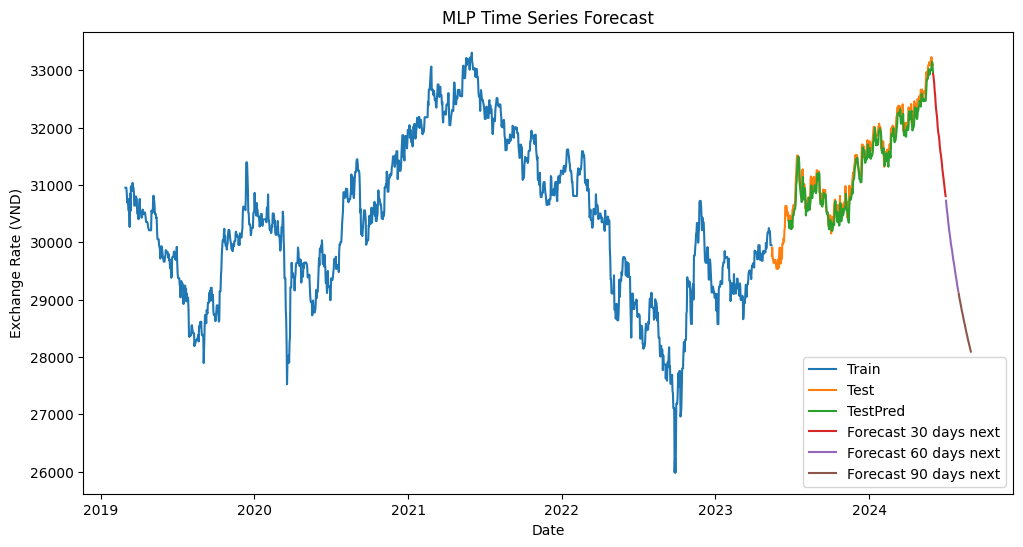

RMSE = 157.48301868801175
MAPE(%) = 0.4143255341724261
MAE = 130.5168797692587


In [16]:
implement_MLP(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[0.9732545]
41
1 day input [0.86636637 0.88970789 0.88861589 0.88861589 0.88861589 0.88520339
 0.8969424  0.87878788 0.8953044  0.91195741 0.90827191 0.90827191
 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291
 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.9732545 ]
1 day output [[0.98375154]]
2 day input [0.88970789 0.88861589 0.88861589 0.88861589 0.88520339 0.8969424
 0.87878788 0.8953044  0.91195741 0.90827191 0.90827191 0.91263991
 0.9033579  0.89148239 0.88861589 0.90745291 0.90745291 0.90745291
 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295
 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.9732545  0.98375154]


17 day output [[1.1057173]]
18 day input [0.90745291 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345
 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.9732545  0.98375154
 0.99331957 1.00073993 0.99940383 1.00846791 1.01135492 1.01865196
 1.02883816 1.04078519 1.04818559 1.05036223 1.05712676 1.07050109
 1.08528364 1.09490097 1.10066664 1.1057173 ]
18 day output [[1.1164228]]
19 day input [0.90745291 0.90526891 0.91004641 0.93147693 0.95345345 0.94840295
 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397 0.97734098
 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.9732545  0.98375154 0.99331957
 1.00073993 0.99940383 1.00846791 1.01135492 1.01865196 1.02883816
 1.04078519 1.04818559 1.05036223 1.05712676 1.07050109 1.08528364
 1.09490097 1.10066664 1.1057173  1.11642277]
19 day output [[1.1253

34 day output [[1.2351243]]
35 day input [0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.9732545
 0.98375154 0.99331957 1.00073993 0.99940383 1.00846791 1.01135492
 1.01865196 1.02883816 1.04078519 1.04818559 1.05036223 1.05712676
 1.07050109 1.08528364 1.09490097 1.10066664 1.1057173  1.11642277
 1.12533593 1.1342293  1.14175439 1.14863968 1.15495682 1.1610564
 1.16831863 1.17677772 1.1851126  1.19100857 1.1976099  1.20432627
 1.21066701 1.21645892 1.22548151 1.23512435]
35 day output [[1.2437531]]
36 day input [0.98826099 0.97229047 0.97147147 0.97147147 0.9732545  0.98375154
 0.99331957 1.00073993 0.99940383 1.00846791 1.01135492 1.01865196
 1.02883816 1.04078519 1.04818559 1.05036223 1.05712676 1.07050109
 1.08528364 1.09490097 1.10066664 1.1057173  1.11642277 1.12533593
 1.1342293  1.14175439 1.14863968 1.15495682 1.1610564  1.16831863
 1.17677772 1.1851126  1.19100857 1.1976099  1.20432627 1.21066701
 1.21645892 1.22548151 1.23512435 1.24375308]
36 day output [[1.250957

51 day output [[1.3807617]]
52 day input [1.05712676 1.07050109 1.08528364 1.09490097 1.10066664 1.1057173
 1.11642277 1.12533593 1.1342293  1.14175439 1.14863968 1.15495682
 1.1610564  1.16831863 1.17677772 1.1851126  1.19100857 1.1976099
 1.20432627 1.21066701 1.21645892 1.22548151 1.23512435 1.24375308
 1.25095701 1.25831127 1.2667042  1.27485645 1.2843014  1.29376924
 1.30152345 1.30844963 1.31747973 1.32793069 1.33763838 1.34537089
 1.35339558 1.36280847 1.37217784 1.38076174]
52 day output [[1.3889824]]
53 day input [1.07050109 1.08528364 1.09490097 1.10066664 1.1057173  1.11642277
 1.12533593 1.1342293  1.14175439 1.14863968 1.15495682 1.1610564
 1.16831863 1.17677772 1.1851126  1.19100857 1.1976099  1.20432627
 1.21066701 1.21645892 1.22548151 1.23512435 1.24375308 1.25095701
 1.25831127 1.2667042  1.27485645 1.2843014  1.29376924 1.30152345
 1.30844963 1.31747973 1.32793069 1.33763838 1.34537089 1.35339558
 1.36280847 1.37217784 1.38076174 1.38898242]
53 day output [[1.3978038

70 day output [[1.5549009]]
71 day input [1.21066701 1.21645892 1.22548151 1.23512435 1.24375308 1.25095701
 1.25831127 1.2667042  1.27485645 1.2843014  1.29376924 1.30152345
 1.30844963 1.31747973 1.32793069 1.33763838 1.34537089 1.35339558
 1.36280847 1.37217784 1.38076174 1.38898242 1.39780378 1.40678287
 1.41576934 1.42435145 1.43302786 1.44188166 1.45099127 1.46036315
 1.46975875 1.47861195 1.48726237 1.49646306 1.50635815 1.5164448
 1.52583742 1.53511965 1.54487157 1.55490088]
71 day output [[1.5648762]]
72 day input [1.21645892 1.22548151 1.23512435 1.24375308 1.25095701 1.25831127
 1.2667042  1.27485645 1.2843014  1.29376924 1.30152345 1.30844963
 1.31747973 1.32793069 1.33763838 1.34537089 1.35339558 1.36280847
 1.37217784 1.38076174 1.38898242 1.39780378 1.40678287 1.41576934
 1.42435145 1.43302786 1.44188166 1.45099127 1.46036315 1.46975875
 1.47861195 1.48726237 1.49646306 1.50635815 1.5164448  1.52583742
 1.53511965 1.54487157 1.55490088 1.5648762 ]
72 day output [[1.57486

87 day output [[1.7300935]]
88 day input [1.35339558 1.36280847 1.37217784 1.38076174 1.38898242 1.39780378
 1.40678287 1.41576934 1.42435145 1.43302786 1.44188166 1.45099127
 1.46036315 1.46975875 1.47861195 1.48726237 1.49646306 1.50635815
 1.5164448  1.52583742 1.53511965 1.54487157 1.55490088 1.5648762
 1.57486475 1.58478177 1.59455276 1.60452843 1.615013   1.62558639
 1.63558507 1.64547825 1.65598345 1.66686666 1.67729759 1.68739307
 1.6977551  1.7085731  1.71944869 1.73009348]
88 day output [[1.7406864]]
89 day input [1.36280847 1.37217784 1.38076174 1.38898242 1.39780378 1.40678287
 1.41576934 1.42435145 1.43302786 1.44188166 1.45099127 1.46036315
 1.46975875 1.47861195 1.48726237 1.49646306 1.50635815 1.5164448
 1.52583742 1.53511965 1.54487157 1.55490088 1.5648762  1.57486475
 1.58478177 1.59455276 1.60452843 1.615013   1.62558639 1.63558507
 1.64547825 1.65598345 1.66686666 1.67729759 1.68739307 1.6977551
 1.7085731  1.71944869 1.73009348 1.74068642]
89 day output [[1.7514043

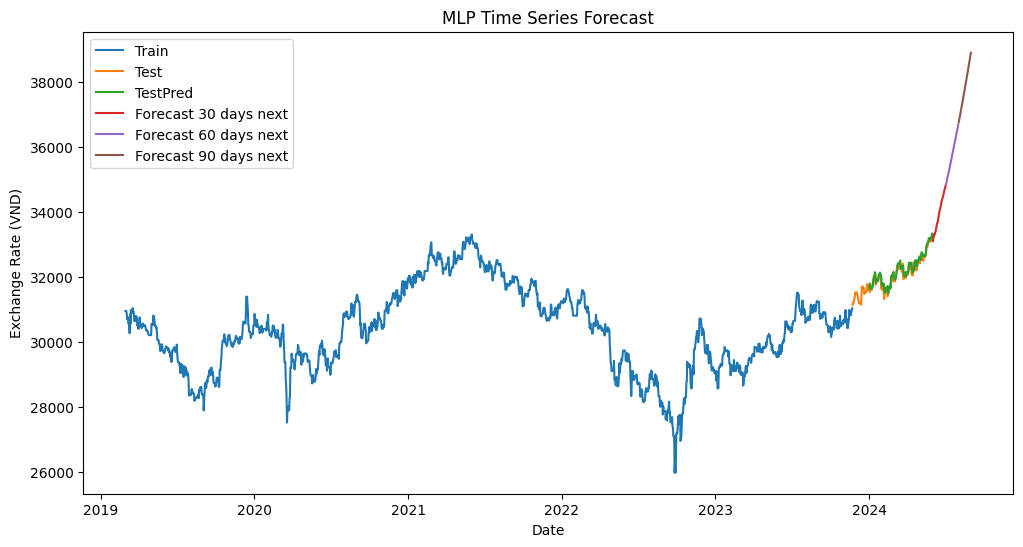

RMSE = 126.79052371440415
MAPE(%) = 0.29618416185252083
MAE = 95.06355365953945


In [17]:
implement_MLP(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND


In [18]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
 ## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
 ## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.03587774]
41
1 day input [0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.03587774]
1 day output [[0.04835286]]
2 day input [0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.03587774 0.04835286]

17 day output [[0.07624558]]
18 day input [0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.03587774 0.04835286
 0.05637171 0.05270901 0.04016834 0.04539476 0.05205782 0.04693688
 0.03577758 0.04188321 0.04883242 0.05047257 0.0552349  0.06469359
 0.07232255 0.07533389 0.07419929 0.07624558]
18 day output [[0.0786958]]
19 day input [0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.03587774 0.04835286 0.05637171
 0.05270901 0.04016834 0.04539476 0.05205782 0.04693688 0.03577758
 0.04188321 0.04883242 0.05047257 0.0552349  0.06469359 0.07232255
 0.07533389 0.07419929 0.07624558 0.0786958 ]
19 day output [[0.08229

36 day output [[0.0828898]]
37 day input [0.02722614 0.02017937 0.02017937 0.03587774 0.04835286 0.05637171
 0.05270901 0.04016834 0.04539476 0.05205782 0.04693688 0.03577758
 0.04188321 0.04883242 0.05047257 0.0552349  0.06469359 0.07232255
 0.07533389 0.07419929 0.07624558 0.0786958  0.08229819 0.08304975
 0.08453761 0.08601962 0.08465279 0.08435723 0.08887269 0.088986
 0.08818263 0.08937708 0.08750623 0.08295592 0.0837896  0.09190996
 0.09648033 0.09340419 0.08481412 0.0828898 ]
37 day output [[0.08634587]]
38 day input [0.02017937 0.02017937 0.03587774 0.04835286 0.05637171 0.05270901
 0.04016834 0.04539476 0.05205782 0.04693688 0.03577758 0.04188321
 0.04883242 0.05047257 0.0552349  0.06469359 0.07232255 0.07533389
 0.07419929 0.07624558 0.0786958  0.08229819 0.08304975 0.08453761
 0.08601962 0.08465279 0.08435723 0.08887269 0.088986   0.08818263
 0.08937708 0.08750623 0.08295592 0.0837896  0.09190996 0.09648033
 0.09340419 0.08481412 0.0828898  0.08634587]
38 day output [[0.08603

53 day output [[0.10792485]]
54 day input [0.07232255 0.07533389 0.07419929 0.07624558 0.0786958  0.08229819
 0.08304975 0.08453761 0.08601962 0.08465279 0.08435723 0.08887269
 0.088986   0.08818263 0.08937708 0.08750623 0.08295592 0.0837896
 0.09190996 0.09648033 0.09340419 0.08481412 0.0828898  0.08634587
 0.0860346  0.08253457 0.08307051 0.08779267 0.09181396 0.0925361
 0.09177975 0.09617227 0.09974448 0.09980405 0.09822834 0.09961043
 0.10119762 0.1023393  0.10510433 0.10792485]
54 day output [[0.11015137]]
55 day input [0.07533389 0.07419929 0.07624558 0.0786958  0.08229819 0.08304975
 0.08453761 0.08601962 0.08465279 0.08435723 0.08887269 0.088986
 0.08818263 0.08937708 0.08750623 0.08295592 0.0837896  0.09190996
 0.09648033 0.09340419 0.08481412 0.0828898  0.08634587 0.0860346
 0.08253457 0.08307051 0.08779267 0.09181396 0.0925361  0.09177975
 0.09617227 0.09974448 0.09980405 0.09822834 0.09961043 0.10119762
 0.1023393  0.10510433 0.10792485 0.11015137]
55 day output [[0.1122101

72 day output [[0.14183514]]
73 day input [0.09648033 0.09340419 0.08481412 0.0828898  0.08634587 0.0860346
 0.08253457 0.08307051 0.08779267 0.09181396 0.0925361  0.09177975
 0.09617227 0.09974448 0.09980405 0.09822834 0.09961043 0.10119762
 0.1023393  0.10510433 0.10792485 0.11015137 0.11221015 0.1148768
 0.11690991 0.1186974  0.12137762 0.12431868 0.12670512 0.12848528
 0.13123152 0.13521583 0.13760948 0.13575315 0.13552895 0.13916329
 0.14041249 0.13882862 0.13862838 0.14183514]
73 day output [[0.14518306]]
74 day input [0.09340419 0.08481412 0.0828898  0.08634587 0.0860346  0.08253457
 0.08307051 0.08779267 0.09181396 0.0925361  0.09177975 0.09617227
 0.09974448 0.09980405 0.09822834 0.09961043 0.10119762 0.1023393
 0.10510433 0.10792485 0.11015137 0.11221015 0.1148768  0.11690991
 0.1186974  0.12137762 0.12431868 0.12670512 0.12848528 0.13123152
 0.13521583 0.13760948 0.13575315 0.13552895 0.13916329 0.14041249
 0.13882862 0.13862838 0.14183514 0.14518306]
74 day output [[0.14585

90 day output [[0.1520758]]


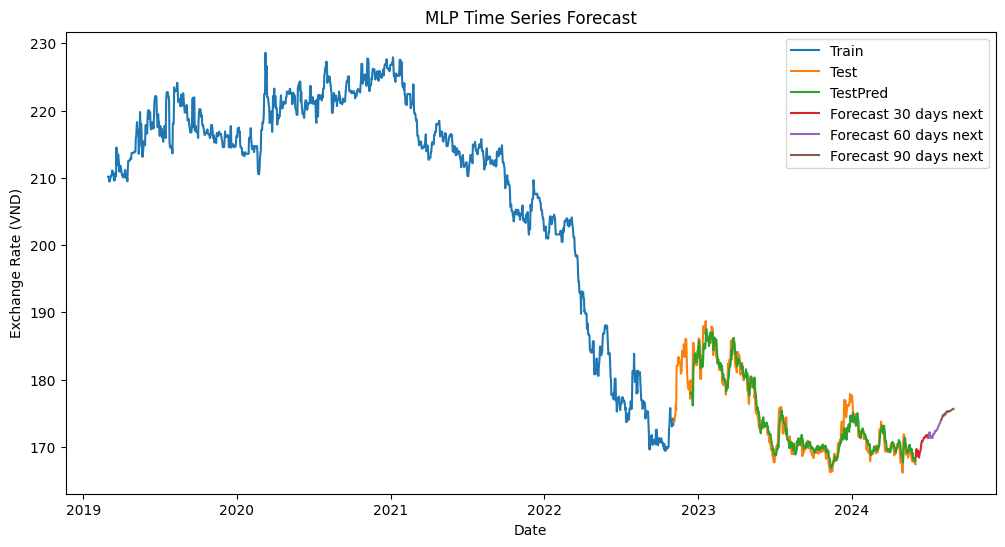

RMSE = 1.4236095018094905
MAPE(%) = 0.5721042103738405
MAE = 1.002753826539908


In [19]:
implement_MLP(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0.03642478]
41
1 day input [0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.03642478]
1 day output [[0.04527142]]
2 day input [0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.03642478 0.04527142]

17 day output [[0.09939413]]
18 day input [0.04596413 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119
 0.0470852  0.0470852  0.0470852  0.04788597 0.04003844 0.03619475
 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721 0.02610506
 0.02466368 0.02722614 0.02017937 0.02017937 0.03642478 0.04527142
 0.05567804 0.056495   0.04584941 0.0516127  0.05941291 0.05867581
 0.04825569 0.05152853 0.05877198 0.05976707 0.06519368 0.07804514
 0.08569752 0.08924571 0.0918412  0.09939413]
18 day output [[0.1046623]]
19 day input [0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.03642478 0.04527142 0.05567804
 0.056495   0.04584941 0.0516127  0.05941291 0.05867581 0.04825569
 0.05152853 0.05877198 0.05976707 0.06519368 0.07804514 0.08569752
 0.08924571 0.0918412  0.09939413 0.1046623 ]
19 day output [[0.10977

36 day output [[0.17059557]]
37 day input [0.02722614 0.02017937 0.02017937 0.03642478 0.04527142 0.05567804
 0.056495   0.04584941 0.0516127  0.05941291 0.05867581 0.04825569
 0.05152853 0.05877198 0.05976707 0.06519368 0.07804514 0.08569752
 0.08924571 0.0918412  0.09939413 0.1046623  0.10977302 0.11803778
 0.12041989 0.1254954  0.13217552 0.13581    0.14251395 0.1430724
 0.1464439  0.15078014 0.15352029 0.15876506 0.16232888 0.16910337
 0.17549628 0.17301607 0.1685818  0.17059557]
37 day output [[0.1762339]]
38 day input [0.02017937 0.02017937 0.03642478 0.04527142 0.05567804 0.056495
 0.04584941 0.0516127  0.05941291 0.05867581 0.04825569 0.05152853
 0.05877198 0.05976707 0.06519368 0.07804514 0.08569752 0.08924571
 0.0918412  0.09939413 0.1046623  0.10977302 0.11803778 0.12041989
 0.1254954  0.13217552 0.13581    0.14251395 0.1430724  0.1464439
 0.15078014 0.15352029 0.15876506 0.16232888 0.16910337 0.17549628
 0.17301607 0.1685818  0.17059557 0.1762339 ]
38 day output [[0.1749052

57 day output [[0.15564652]]
58 day input [0.1046623  0.10977302 0.11803778 0.12041989 0.1254954  0.13217552
 0.13581    0.14251395 0.1430724  0.1464439  0.15078014 0.15352029
 0.15876506 0.16232888 0.16910337 0.17549628 0.17301607 0.1685818
 0.17059557 0.1762339  0.17490524 0.17048521 0.17130877 0.17112011
 0.17146561 0.17443492 0.17266749 0.17075969 0.16782537 0.1667206
 0.16588168 0.16367182 0.16362789 0.16124335 0.15959041 0.15987398
 0.15831846 0.15814786 0.1571196  0.15564652]
58 day output [[0.15415563]]
59 day input [0.10977302 0.11803778 0.12041989 0.1254954  0.13217552 0.13581
 0.14251395 0.1430724  0.1464439  0.15078014 0.15352029 0.15876506
 0.16232888 0.16910337 0.17549628 0.17301607 0.1685818  0.17059557
 0.1762339  0.17490524 0.17048521 0.17130877 0.17112011 0.17146561
 0.17443492 0.17266749 0.17075969 0.16782537 0.1667206  0.16588168
 0.16367182 0.16362789 0.16124335 0.15959041 0.15987398 0.15831846
 0.15814786 0.1571196  0.15564652 0.15415563]
59 day output [[0.1536501

78 day output [[0.1750856]]
79 day input [0.17048521 0.17130877 0.17112011 0.17146561 0.17443492 0.17266749
 0.17075969 0.16782537 0.1667206  0.16588168 0.16367182 0.16362789
 0.16124335 0.15959041 0.15987398 0.15831846 0.15814786 0.1571196
 0.15564652 0.15415563 0.15365015 0.1547772  0.15415256 0.15365835
 0.15593703 0.15681112 0.15653753 0.15505132 0.15580358 0.15822868
 0.15850063 0.15995644 0.16036265 0.16162504 0.16596386 0.16850805
 0.16975813 0.17072847 0.17281841 0.1750856 ]
79 day output [[0.17663208]]
80 day input [0.17130877 0.17112011 0.17146561 0.17443492 0.17266749 0.17075969
 0.16782537 0.1667206  0.16588168 0.16367182 0.16362789 0.16124335
 0.15959041 0.15987398 0.15831846 0.15814786 0.1571196  0.15564652
 0.15415563 0.15365015 0.1547772  0.15415256 0.15365835 0.15593703
 0.15681112 0.15653753 0.15505132 0.15580358 0.15822868 0.15850063
 0.15995644 0.16036265 0.16162504 0.16596386 0.16850805 0.16975813
 0.17072847 0.17281841 0.1750856  0.17663208]
80 day output [[0.1793

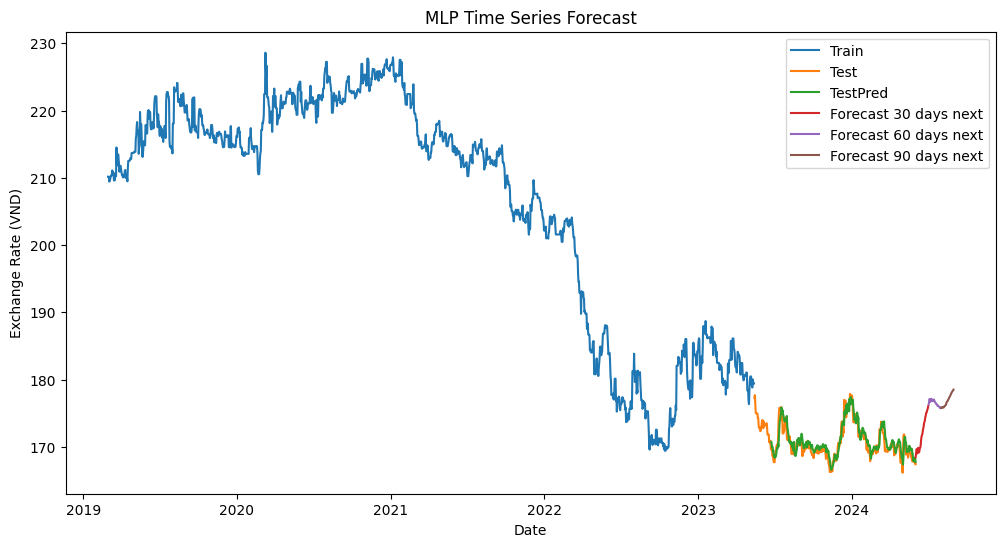

RMSE = 1.102042035864136
MAPE(%) = 0.501188579087102
MAE = 0.855914127438567


In [20]:
implement_MLP(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[0.02005748]
41
1 day input [0.0578155  0.03971813 0.02370275 0.02370275 0.02370275 0.03539398
 0.01713645 0.         0.05188981 0.08728379 0.09096733 0.09096733
 0.07399103 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413
 0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.02005748]
1 day output [[0.02670909]]
2 day input [0.03971813 0.02370275 0.02370275 0.02370275 0.03539398 0.01713645
 0.         0.05188981 0.08728379 0.09096733 0.09096733 0.07399103
 0.06278027 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413
 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.02005748 0.02670909]
2

18 day output [[0.07620022]]
19 day input [0.04596413 0.04436259 0.03587444 0.04228059 0.06374119 0.0470852
 0.0470852  0.0470852  0.04788597 0.04003844 0.03619475 0.0318706
 0.02674568 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368
 0.02722614 0.02017937 0.02017937 0.02005748 0.02670909 0.03863434
 0.04229651 0.0385241  0.0395221  0.04334822 0.04949135 0.04417347
 0.04649356 0.05208741 0.054363   0.0548955  0.05705658 0.06434616
 0.06923345 0.06892867 0.07269015 0.07620022]
19 day output [[0.08030511]]
20 day input [0.04436259 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852
 0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.02005748 0.02670909 0.03863434 0.04229651
 0.0385241  0.0395221  0.04334822 0.04949135 0.04417347 0.04649356
 0.05208741 0.054363   0.0548955  0.05705658 0.06434616 0.06923345
 0.06892867 0.07269015 0.07620022 0.08030511]
20 day output [[0.08615

35 day output [[0.14329071]]
36 day input [0.02466368 0.02722614 0.02017937 0.02017937 0.02005748 0.02670909
 0.03863434 0.04229651 0.0385241  0.0395221  0.04334822 0.04949135
 0.04417347 0.04649356 0.05208741 0.054363   0.0548955  0.05705658
 0.06434616 0.06923345 0.06892867 0.07269015 0.07620022 0.08030511
 0.08615541 0.08865982 0.09440859 0.09915963 0.10473466 0.10984442
 0.11213616 0.11706433 0.12022126 0.12384521 0.12734593 0.12973639
 0.13373996 0.13788101 0.14221054 0.14329071]
36 day output [[0.14196734]]
37 day input [0.02722614 0.02017937 0.02017937 0.02005748 0.02670909 0.03863434
 0.04229651 0.0385241  0.0395221  0.04334822 0.04949135 0.04417347
 0.04649356 0.05208741 0.054363   0.0548955  0.05705658 0.06434616
 0.06923345 0.06892867 0.07269015 0.07620022 0.08030511 0.08615541
 0.08865982 0.09440859 0.09915963 0.10473466 0.10984442 0.11213616
 0.11706433 0.12022126 0.12384521 0.12734593 0.12973639 0.13373996
 0.13788101 0.14221054 0.14329071 0.14196734]
37 day output [[0.14

53 day output [[0.13632743]]
54 day input [0.06434616 0.06923345 0.06892867 0.07269015 0.07620022 0.08030511
 0.08615541 0.08865982 0.09440859 0.09915963 0.10473466 0.10984442
 0.11213616 0.11706433 0.12022126 0.12384521 0.12734593 0.12973639
 0.13373996 0.13788101 0.14221054 0.14329071 0.14196734 0.14374144
 0.14672345 0.14817576 0.14898877 0.1498549  0.15262489 0.153069
 0.15253775 0.15255915 0.15242428 0.1520889  0.1498151  0.14738432
 0.14532764 0.14318991 0.14047967 0.13632743]
54 day output [[0.1331498]]
55 day input [0.06923345 0.06892867 0.07269015 0.07620022 0.08030511 0.08615541
 0.08865982 0.09440859 0.09915963 0.10473466 0.10984442 0.11213616
 0.11706433 0.12022126 0.12384521 0.12734593 0.12973639 0.13373996
 0.13788101 0.14221054 0.14329071 0.14196734 0.14374144 0.14672345
 0.14817576 0.14898877 0.1498549  0.15262489 0.153069   0.15253775
 0.15255915 0.15242428 0.1520889  0.1498151  0.14738432 0.14532764
 0.14318991 0.14047967 0.13632743 0.1331498 ]
55 day output [[0.13009

73 day output [[0.09935985]]
74 day input [0.14221054 0.14329071 0.14196734 0.14374144 0.14672345 0.14817576
 0.14898877 0.1498549  0.15262489 0.153069   0.15253775 0.15255915
 0.15242428 0.1520889  0.1498151  0.14738432 0.14532764 0.14318991
 0.14047967 0.13632743 0.1331498  0.13009673 0.12667824 0.12344779
 0.12003492 0.11738314 0.11472966 0.11201572 0.10997815 0.10766819
 0.10610972 0.10502997 0.10406847 0.10280365 0.10107803 0.10058972
 0.10079125 0.10064921 0.09999539 0.09935985]
74 day output [[0.09958839]]
75 day input [0.14329071 0.14196734 0.14374144 0.14672345 0.14817576 0.14898877
 0.1498549  0.15262489 0.153069   0.15253775 0.15255915 0.15242428
 0.1520889  0.1498151  0.14738432 0.14532764 0.14318991 0.14047967
 0.13632743 0.1331498  0.13009673 0.12667824 0.12344779 0.12003492
 0.11738314 0.11472966 0.11201572 0.10997815 0.10766819 0.10610972
 0.10502997 0.10406847 0.10280365 0.10107803 0.10058972 0.10079125
 0.10064921 0.09999539 0.09935985 0.09958839]
75 day output [[0.09

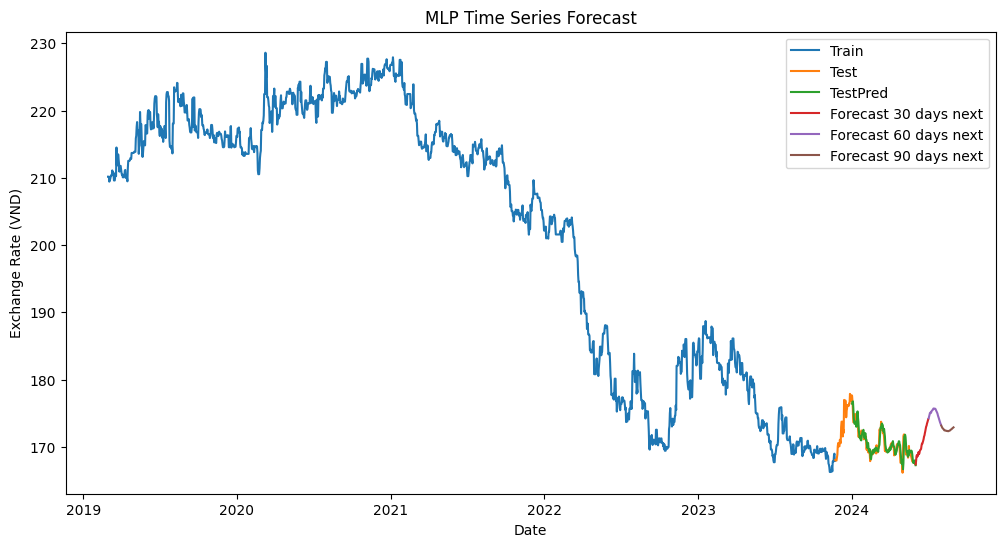

RMSE = 0.9174077444908741
MAPE(%) = 0.39306756585430386
MAE = 0.6706301879882822


In [21]:
implement_MLP(train_jpy_3_sc, test_jpy_3_sc)